In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp
import mesh_tensorflow as mtf

import flowpm
import flowpm.mesh_ops as mpm
import flowpm.mtfpm as mtfpm
import flowpm.mesh_utils as mesh_utils
from astropy.cosmology import Planck15
from flowpm.tfpm import PerturbationGrowth
from flowpm import linear_field, lpt_init, nbody, cic_paint
from flowpm.utils import r2c3d, c2r3d

sys.path.append('../utils/')
import tools
import diagnostics as dg

import contextlib
import functools
import math, time
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
import scipy.optimize as sopt



In [3]:
from recurrent_inference import rim, ConvRIM3D
from convolutional_recurrent import ConvLSTM3DCell
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers.convolutional_recurrent import ConvLSTM2DCell
from tensorflow.python.keras.layers import LSTMCell, LSTM, Dense, Conv3D



In [4]:
bs, nc = 100, 16
nsteps = 3
a0, a, nsteps = 0.1, 1.0,  nsteps
stages = np.linspace(a0, a, nsteps, endpoint=True)

klin = np.loadtxt('../data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../data//Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)
# Compute necessary Fourier kernels                                                                                                                           
kvec = tools.fftk((nc, nc, nc), boxsize=nc, symmetric=False)
kmesh = (sum(k**2 for k in kvec)**0.5).astype(np.float32)
priorwt = ipklin(kmesh)


<ipython-input-4-0d1dad7ca900>:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmesh = (sum(k**2 for k in kvec)**0.5).astype(np.float32)


In [166]:
dpath = '../data/rim-data/L%04d_N%03d_T%02d/'%(bs, nc, nsteps)

alldata = np.array([np.load(dpath + '%04d.npy'%i) for i in range(650)]).astype(float32)
# alldata = np.expand_dims(alldata, axis=2)
traindata, testdata = alldata[:500], alldata[500:]
ic, fin = traindata[:1,0], traindata[:1,1]


In [209]:
def get_ps(iterand, truth):
    ic, fin = truth
    ic1, fin1 = iterand

    pks = []
    if abs(ic1[0].mean()) < 1e-3: ic1[0] += 1
    #if abs(ic[0].mean()) < 1e-3: ic[0] += 1                                                                                                                  
    k, p1 = tools.power(ic1[0]+1, boxsize=bs)
    k, p2 = tools.power(ic[0]+1, boxsize=bs)
    k, p12 = tools.power(ic1[0]+1, f2=ic[0]+1, boxsize=bs)
    pks.append([p1, p2, p12])
    if fin1[0].mean() < 1e-3: fin1[0] += 1
    if fin[0].mean() < 1e-3: fin[0] += 1
    k, p1 = tools.power(fin1[0], boxsize=bs)
    k, p2 = tools.power(fin[0], boxsize=bs)
    k, p12 = tools.power(fin1[0], f2=fin[0], boxsize=bs)
    pks.append([p1, p2, p12])

    return k, pks

# def plot_ps(pks, fig, ax):
#     fig, ax = plt.subplots(1, 3, figsize=(12,3.5))
#     ax[0].plot(k, pks[0][0], 'C0', lw=2, label='Recon')
#     ax[0].plot(k, pks[0][1], 'C0--', lw=2, label='Truth')
#     ax[0].plot(k, pks[1][0], 'C1', lw=2)
#     ax[0].plot(k, pks[1][1], 'C1--', lw=2)
#     ax[0].loglog()
#     ax[0].set_ylabel('P(k)')

#     p1, p2, p12 = pks[0]
#     ax[1].plot(k, p12/(p1*p2)**0.5, 'C0', lw=2, label='Init')
#     ax[2].plot(k, (p1/p2)**0.5, 'C0', lw=2, label='')

#     p1, p2, p12 = pks[1]
#     ax[1].plot(k, p12/(p1*p2)**0.5, 'C1', lw=2, label='Final')
#     ax[2].plot(k, (p1/p2)**0.5, 'C1', lw=2, label='')

#     ax[1].semilogx()
#     ax[2].semilogx()
#     ax[1].set_ylim(-0.1, 1.1)
#     ax[2].set_ylim(-0.1, 2.)
#     ax[1].set_ylabel('Cross correlation', fontsize=fsize)
#     ax[2].set_ylabel('Transfer Function', fontsize=fsize)

#     for axis in ax:
#         axis.legend(fontsize=fsize)
#         axis.grid(which='both')
#         axis.set_xlabel('k (h/Mpc)', fontsize=fsize)



# GD

In [6]:
@tf.function
def pm(linear):
    state = lpt_init(linear, a0=0.1, order=1)
    final_state = nbody(state,  stages, nc)
    tfinal_field = cic_paint(tf.zeros_like(linear), final_state[0])
    return tfinal_field


@tf.function
def recon_prototype(linear, data, Rsm, anneal=True):
    """                                                                                                                                                   
    """
    print(linear)
#     linear = tf.reshape(linear, data.shape)
    final_field = pm(linear)

    residual = final_field - data #.astype(np.float32)
    base = residual

    if anneal :
        print("\nAdd annealing section to graph\n")
        Rsmsq = tf.multiply(Rsm*bs/nc, Rsm*bs/nc)
        smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
        basek = r2c3d(base, norm=nc**3)
        basek = tf.multiply(basek, tf.cast(smwts, tf.complex64))
        base = c2r3d(basek, norm=nc**3)

    chisq = tf.multiply(base, base)
    chisq = tf.reduce_sum(chisq)
    chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

    #Prior                                                                                                                                                
    lineark = r2c3d(linear, norm=nc**3)
    priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
    prior = tf.multiply(prior, 1/nc**3, name='prior')
    #                                                                                                                                                     
    loss = chisq + prior

    return loss


@tf.function
def recon_loss_and_grad(x, y, Rsm):
    print("val and grad : ", x.shape)
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype(x, y, Rsm)
    grad = tape.gradient(loss, x)
    return loss, grad

@tf.function
def recon_grad(x, y, Rsm):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype(x, y, Rsm)
    grad = tape.gradient(loss, [x])
    return grad




# Create an optimizer for Adam.                                                                                                                           
opt = tf.keras.optimizers.Adam(learning_rate=0.1)



In [167]:
RRs = [1, 0]
optimizer = 'adam'
niter = 50


#Loop it Reconstruction                                                                                                                                   
##Reconstruction                                                                                                                                          
x0 = np.random.normal(0, 1, nc**3).reshape(fin.shape).astype(np.float32)
linear = tf.Variable(name='linmesh', shape=(1, nc, nc, nc), dtype=tf.float32,
                         initial_value=x0, trainable=True)

for iR, RR in enumerate(RRs):

    for i in range(niter):
        grads = recon_grad(linear, tf.constant(fin, dtype=tf.float32), tf.constant(RR, dtype=tf.float32))
#         recon_prototype(linear, tf.constant(fin), tf.constant(0., dtype=tf.float32))
        opt.apply_gradients(zip(grads, [linear]))
    minic = linear.numpy().reshape(fin.shape)
    
    x0 = minic
    
minfin = pm(tf.constant(minic)).numpy()

<tf.Variable 'linmesh:0' shape=(1, 16, 16, 16) dtype=float32>

Add annealing section to graph



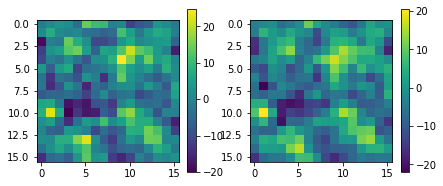

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
im = ax[0].imshow(ic[0].sum(axis=0))
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(minic[0].sum(axis=0))
plt.colorbar(im, ax=ax[1])

../utils/diagnostics.py:102: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(k, p12/(p1*p2)**0.5, 'C0', lw=2, label='Init')
../utils/diagnostics.py:103: RuntimeWarning: invalid value encountered in true_divide
  ax[2].plot(k, (p1/p2)**0.5, 'C0', lw=2, label='')
../utils/diagnostics.py:106: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(k, p12/(p1*p2)**0.5, 'C1', lw=2, label='Final')
../utils/diagnostics.py:107: RuntimeWarning: invalid value encountered in true_divide
  ax[2].plot(k, (p1/p2)**0.5, 'C1', lw=2, label='')
No handles with labels found to put in legend.


(<Figure size 864x252 with 3 Axes>,
 array([<AxesSubplot:xlabel='k (h/Mpc)', ylabel='P(k)'>,
        <AxesSubplot:xlabel='k (h/Mpc)', ylabel='Cross correlation'>,
        <AxesSubplot:xlabel='k (h/Mpc)', ylabel='Transfer Function'>],
       dtype=object))

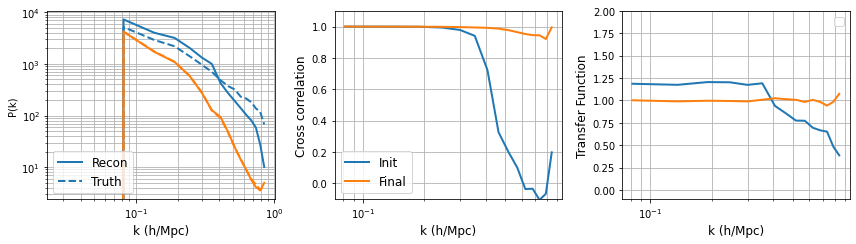

In [169]:
dg.save2ptfig(0, [minic, minfin], [ic, fin], None, bs, save=False, retfig=True)


# Code RIM

In [80]:


@tf.function
def recon_prototype_noanneal(linear, data):
    """                                                                                                                                                   
    """
    final_field = pm(linear)

    residual = final_field - data #.astype(np.float32)

    chisq = tf.multiply(residual, residual)
    chisq = tf.reduce_sum(chisq)
    chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

    #Prior                                                                                                                                                
    lineark = r2c3d(linear, norm=nc**3)
    priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
    prior = tf.multiply(prior, 1/nc**3, name='prior')
    #                                                                                                                                                     
    loss = chisq + prior

    return loss


@tf.function
def recon_noanneal_grad(x, y):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype_noanneal(x, y)
    grad = tape.gradient(loss, x)
    return grad




In [132]:
class myRIM3D(tf.keras.Model):

    def __init__(self, cell, output_layer, niter):
        super(myRIM3D, self).__init__()
        self.cell = cell
        self.output_layer = output_layer
        self.niter = niter

            
#     def call(self, x_init, y, grad_fn, outputs_ta, states_ta, grad_args=[], initstates = None, return_steps=False):
    def call(self, x_init, y, grad_fn, grad_args=[], initstates = None, return_steps=False):
        
        outputs_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
        states_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
        
        if initstates is None: 
#             stateshape = x_init.shape[:-1] + tuple([self.cell.output_size])
            stateshape = x_init.shape + tuple([self.cell.filters])
            initstates = [tf.zeros(stateshape), tf.zeros(stateshape)]
    
        i = tf.constant(0, dtype=tf.int32)
        curr_state = initstates
        curr_pos = x_init
        
        
        def body(i, pos, states):  
            gradient = grad_fn(pos, y, *grad_args)
            cell_state_concat = tf.stack([pos, gradient], axis=-1)
#             cell_state_concat = tf.concat([pos, gradient], axis=-1)
            delta_pos, new_state = self.cell(cell_state_concat, states)
            delta_pos = self.output_layer(delta_pos)[...,0]
            new_pos = pos + delta_pos
            return i +1 , new_pos, new_state
        
        while tf.less(i, tf.constant(self.niter)):
            outputs_ta = outputs_ta.write(i, curr_pos)
            states_ta = states_ta.write(i, curr_state)
            i, curr_pos, curr_state =  body(i, curr_pos, curr_state)
        outputs_ta = outputs_ta.write(i, curr_pos)
        states_ta = states_ta.write(i, curr_state)
        return outputs_ta.stack(), states_ta.stack()


In [172]:
niter = 10
cellsize = 64
cell = ConvLSTM3DCell(cellsize, kernel_size=3, padding='SAME')
cell.build(input_shape=[None, nc, nc, nc, 2])

idx = np.random.randint(0, traindata.shape[0], 10)
xx, yy = traindata[idx, 0].astype(float32), traindata[idx, 1].astype(float32), 
# xx, yy = np.expand_dims(xx, -1), np.expand_dims(yy, -1)
x_init = np.random.normal(size=xx.size).reshape(xx.shape).astype(float32)
stateshape = x_init.shape + tuple([cell.filters])
initstates = [tf.zeros(stateshape), tf.zeros(stateshape)]
cell(tf.constant(tf.stack([xx, xx], axis=-1)), initstates);


In [173]:
output_layer = Conv3D(1, kernel_size=3, trainable=False, padding='SAME')
output_layer.build(input_shape=(None, nc, nc, nc, cellsize))

testrim = myRIM3D(cell, output_layer, niter=10)

# outputs_ta = tf.TensorArray(size=niter+1, dtype=tf.float32)
# states_ta = tf.TensorArray(size=niter+1, dtype=tf.float32)
out, states = testrim(x_init=tf.constant(xx), 
                      y=tf.constant(yy), 
                      grad_fn=recon_noanneal_grad)




In [174]:
# Create an optimizer for Adam.                                                                                                                           
opt = tf.keras.optimizers.Adam(learning_rate=0.1)


# @tf.function
def rim_train(x_true, x_init, y):
    with tf.GradientTape() as tape:
        x_pred, states = testrim(x_init, y, recon_noanneal_grad)
        loss = tf.reduce_mean(tf.square((x_true- x_pred)))
        
    gradients = tape.gradient(loss, testrim.trainable_variables)
    opt.apply_gradients(zip(gradients, testrim.trainable_variables))
    return loss
    
    

In [151]:
# idx = np.random.randint(0, X_train.shape[0], 100)
# xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)

# with tf.GradientTape() as tape:
#     tape.watch(testrim.trainable_variables)
#     out, states = testrim(tf.constant(xinit),  tf.constant(yy), grad, [tf.constant(A)])
#     testloss = tf.reduce_sum((out - tf.constant(xx)**2))
# testgrads  = tape.gradient(testloss, testrim.trainable_variables)
    


In [177]:
losses = []
piter = 10 

start = time.time()
for i in range(1000):
    idx = np.random.randint(0, traindata.shape[0], 8)
    xx, yy = traindata[idx, 0].astype(float32), traindata[idx, 1].astype(float32), 
#     x_init = np.random.normal(size=xx.size).reshape(xx.shape).astype(float32)
    x_init = np.random.normal(size=xx.size).reshape(xx.shape).astype(float32)
    
    losses.append(rim_train(x_true=tf.constant(xx), 
                            x_init=tf.constant(x_init), 
                            y=tf.constant(yy)).numpy())
    
    if i%piter == 0: 
        print("Loss at iteration %d : "%i, losses[-1])
        print("Time taken for %d iterations "%piter, time.time() - start)
        start = time.time()
#     testrim(tf.constant(xinit), tf.constant(yy), grad, [tf.constant(A)])
#     print(testrim.cell.kernel)    

Loss at iteration 0 :  3.2836554
Time taken for 10 iterations  1.2167747020721436
Loss at iteration 10 :  2.8167899
Time taken for 10 iterations  10.90106987953186
Loss at iteration 20 :  2.5010881
Time taken for 10 iterations  11.950916528701782
Loss at iteration 30 :  2.4634902
Time taken for 10 iterations  11.938730239868164
Loss at iteration 40 :  2.4401495
Time taken for 10 iterations  12.201103687286377
Loss at iteration 50 :  2.4091234
Time taken for 10 iterations  12.317014455795288
Loss at iteration 60 :  2.3866808
Time taken for 10 iterations  12.931225061416626
Loss at iteration 70 :  2.3608942
Time taken for 10 iterations  12.90269136428833
Loss at iteration 80 :  2.3847876
Time taken for 10 iterations  11.67801547050476
Loss at iteration 90 :  2.3964818
Time taken for 10 iterations  13.184093236923218
Loss at iteration 100 :  2.3305166
Time taken for 10 iterations  12.478868246078491
Loss at iteration 110 :  2.3006897
Time taken for 10 iterations  11.866273403167725
Loss a

Loss at iteration 990 :  1.9304332
Time taken for 10 iterations  11.352291822433472


[]

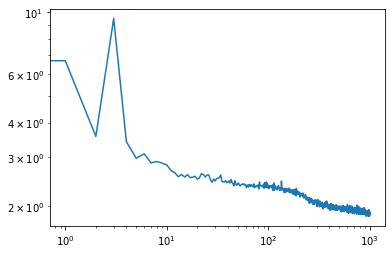

In [178]:
plt.plot(losses)
# plt.semilogx()
plt.loglog()

In [243]:
idx = np.random.randint(0, traindata.shape[0], 1)
xx, yy = traindata[idx, 0].astype(float32), traindata[idx, 1].astype(float32), 
x_init = np.random.normal(size=xx.size).reshape(xx.shape).astype(float32)
# x_init = yy.copy()
out, states = testrim(x_init=tf.constant(x_init), 
                      y=tf.constant(yy), 
                      grad_fn=recon_noanneal_grad)

out = out.numpy()
pred = out[-1]
cstate = out[1][:, 0]


-28.125889 23.664955


Text(0.5, 1.0, 'RIM 10 step')

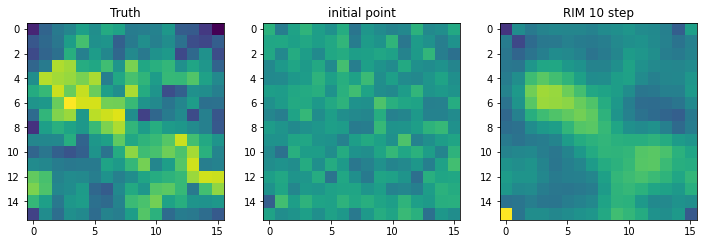

In [244]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
vmin, vmax = xx[0].sum(axis=0).min(), xx[0].sum(axis=0).max()
print(vmin, vmax)
ax[0].imshow(xx[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[0].set_title('Truth')
ax[1].imshow(x_init[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[1].set_title('initial point')
ax[2].imshow(pred[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[2].set_title('RIM 10 step')

<ipython-input-245-9761f8f0f74b>:5: RuntimeWarning: invalid value encountered in true_divide
  ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d--'%i)
<ipython-input-245-9761f8f0f74b>:6: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d--'%i)
<ipython-input-245-9761f8f0f74b>:5: RuntimeWarning: invalid value encountered in true_divide
  ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d--'%i)
<ipython-input-245-9761f8f0f74b>:6: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d--'%i)
<ipython-input-245-9761f8f0f74b>:10: RuntimeWarning: invalid value encountered in true_divide
  ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d'%i)
<ipython-input-245-9761f8f0f74b>:11: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d'%i)
<ipython-input-245-9761f8f0f74b>:10: RuntimeWarning: invalid value encountered in tr

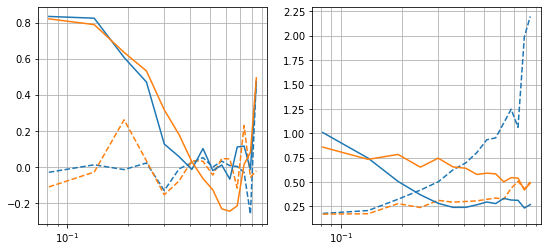

In [245]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

k, pks = get_ps([out[0], pm(out[0]).numpy()], [xx, yy])
for i in range(2):
    ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d--'%i)
    ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d--'%i)

k, pks = get_ps([out[-1], pm(out[-1]).numpy()], [xx, yy])
for i in range(2):
    ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d'%i)
    ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d'%i)

for axis in ax: 
    axis.semilogx()
    axis.grid(which='both')

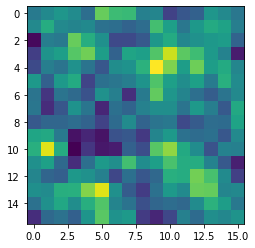

In [230]:
plt.imshow(ic[0].sum(axis=0))

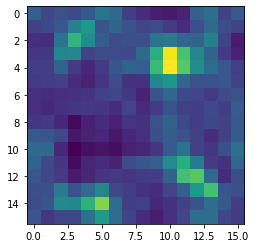

In [231]:
plt.imshow(fin[0].sum(axis=0))

<ipython-input-234-29cdf2bc0ff3>:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k, p12/(p1*p2)**0.5)


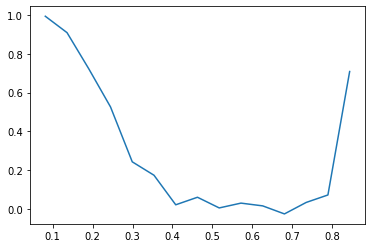

In [234]:
k, p1 = tools.power(yy[0], boxsize=bs)
k, p2 = tools.power(xx[0]+1, boxsize=bs)
k, p12 = tools.power(yy[0], xx[0]+1, boxsize=bs)


plt.plot(k, p12/(p1*p2)**0.5)

In [193]:
ii = -1
out[ii, 0].min(), out[ii, 0].max(), out[ii, 0].mean(), out[ii, 0].std()

(-1.9439884, 2.5989637, -0.016343972, 0.6222725)

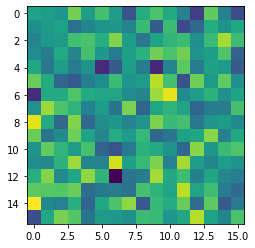

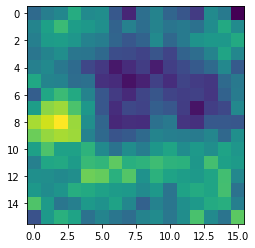

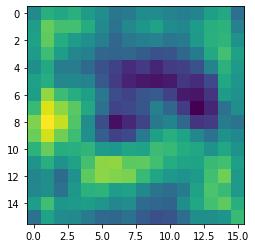

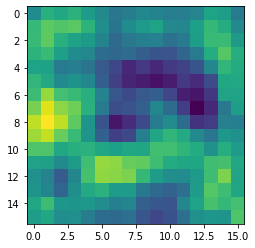

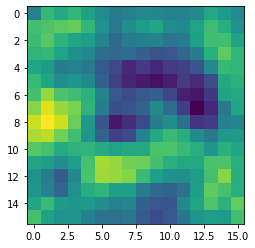

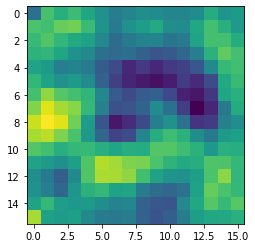

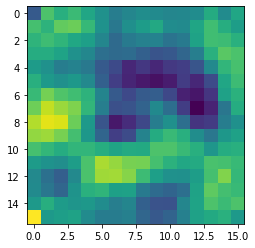

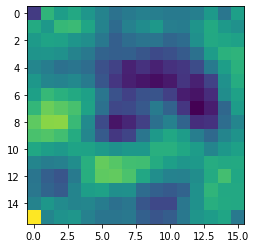

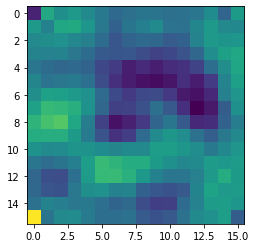

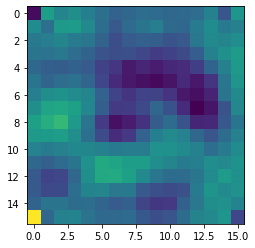

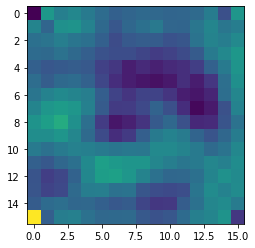

In [198]:
for i in range(out.shape[0]):
    plt.imshow(out[i, 0].sum(axis=0))
    plt.show()

### Test

In [32]:
idx = np.random.randint(0, X_train.shape[0], 32)
xinit, xx, yy, A = X0_test.astype(float32), X_test.astype(float32), Y_test.astype(float32), A_test
out = testrim(tf.constant(xinit), tf.constant(yy), tf_loss_grad, [tf.constant(A)])
pred = out[0].numpy()
cstate = out[1][:, 0]

# list_xt_rim, losses = [], []
# for (x0, y, x, A) in zip(X0_test, Y_test, X_test, A_test):
#     list_xt, loss = rim.forward_sequence(x0, y, x, A, "test")
#     list_xt_rim.append(list_xt)
#     losses.append(loss.data.numpy()[0])
# list_xt_rim = np.array(list_xt_rim)
# losses = np.array(losses)



In [33]:
list_xt_rim = np.array([pred[:, i, :] for i in range(pred.shape[1])])
testlossrim = ((X_test - list_xt_rim[:, -1, :])**2).sum(axis=-1)**0.5
testlossgd = ((X_test - list_xt_gd[:, -1, :])**2).sum(axis=-1)**0.5

181
RIM Loss: 1.505905
GD Loss: 3.553873


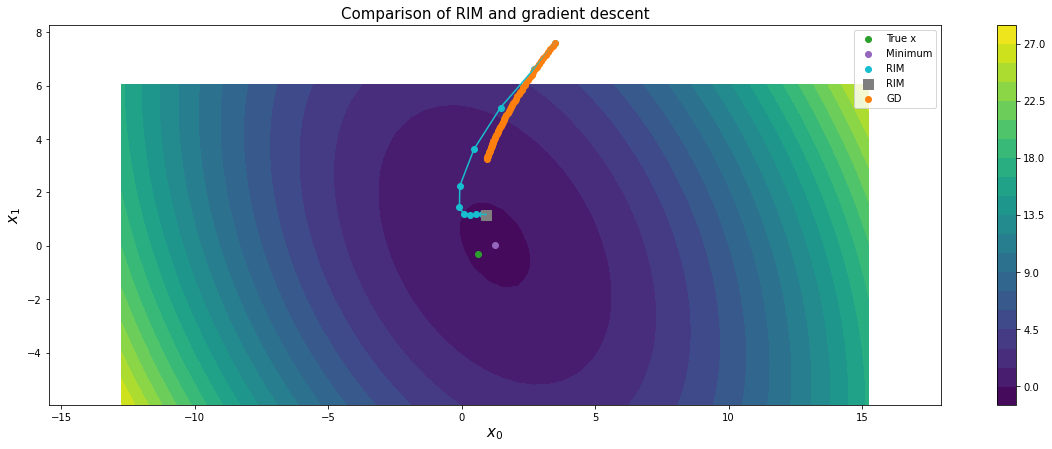

In [34]:
i_example = np.random.randint(pred.shape[1])
print(i_example)

print("RIM Loss: {0:5f}".format(float(testlossrim[i_example])))
print("GD Loss: {0:5f}".format(float(testlossgd[i_example])))

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

# Plot the loss
plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar();
plt.scatter(X_test[i_example][0], X_test[i_example][1], c=colormap[2], zorder=10, label="True x")
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4], zorder=10, label="Minimum")

# Plot the RIM results
plt.plot(list_xt_rim[i_example,:,0], list_xt_rim[i_example,:,1], color=colormap[9])
plt.scatter(list_xt_rim[i_example,:,0], list_xt_rim[i_example,:,1], color=colormap[9], label="RIM")
plt.scatter(list_xt_rim[i_example,-1,0], list_xt_rim[i_example,-1,1], color=colormap[7], label="RIM", marker='s', s=100)

# Plot the GD results
plt.plot(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], color=colormap[1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1], label="GD")

plt.xlabel("$x_0$", size=15)
plt.ylabel("$x_1$", size=15)
plt.title("Comparison of RIM and gradient descent", size=15)
plt.legend()
# plt.savefig("screenshots/toy-model-1-sample.png")

(array([165., 143.,  76.,  52.,  30.,  12.,   8.,   8.,   2.,   2.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       dtype=float32),
 <BarContainer object of 10 artists>)

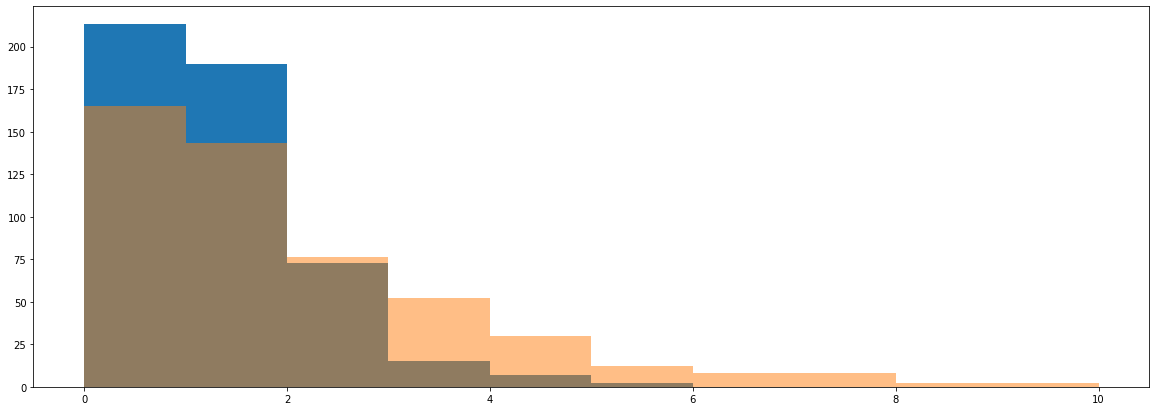

In [35]:
plt.hist(testlossrim, range=(0, 10))
plt.hist(testlossgd, alpha=0.5, range=(0, 10))


In [36]:


dist_rim = [np.linalg.norm(list_xt_rim[i][-1] - X_min_test[i]) for i in range(len(X_test))]
dist_gd = [np.linalg.norm(list_xt_gd[i][-1] - X_min_test[i]) for i in range(len(X_test))]

mean_rim = np.mean(dist_rim)
mean_gd = np.mean(dist_gd)

std_rim = np.std(dist_rim)
std_gd = np.std(dist_gd)

print("Average distance to min x with RIM: ", mean_rim)
print("Average distance to min x with GD: ", mean_gd)

print("STD distance to min x with RIM: ", std_rim)
print("STD distance to min x with GD: ", std_gd)


Average distance to min x with RIM:  0.97712916
Average distance to min x with GD:  1.553502
STD distance to min x with RIM:  0.76428545
STD distance to min x with GD:  1.522179


In [37]:

binwidth = 0.5

dist_rim = [np.linalg.norm(list_xt_rim[i][-1] - X_test[i]) for i in range(len(X_test))]
dist_gd = [np.linalg.norm(list_xt_gd[i][-1] - X_test[i]) for i in range(len(X_test))]

mean_rim = np.mean(dist_rim)
mean_gd = np.mean(dist_gd)

std_rim = np.std(dist_rim)
std_gd = np.std(dist_gd)

print("Average distance to true x with RIM: ", mean_rim)
print("Average distance to true x with GD: ", mean_gd)

print("STD distance to true x with RIM: ", std_rim)
print("STD distance to true x with GD: ", std_gd)

Average distance to true x with RIM:  1.3215481
Average distance to true x with GD:  2.0748
STD distance to true x with RIM:  0.8945784
STD distance to true x with GD:  1.8070525
